# Time Series Forecast XGBoost

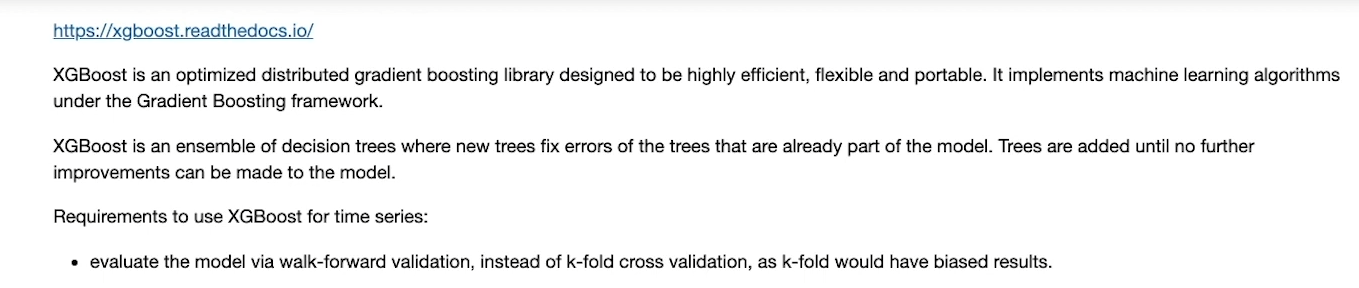

In [1]:
import IPython

print(IPython.sys_info())

{'commit_hash': '9cc5c342c',
 'commit_source': 'installation',
 'default_encoding': 'cp1252',
 'ipython_path': 'C:\\Users\\User\\.conda\\envs\\tf2.4\\Lib\\site-packages\\IPython',
 'ipython_version': '7.26.0',
 'os_name': 'nt',
 'platform': 'Windows-10-10.0.19041-SP0',
 'sys_executable': 'C:\\Users\\User\\.conda\\envs\\tf2.4\\python.exe',
 'sys_platform': 'win32',
 'sys_version': '3.8.0 (default, Nov  6 2019, 16:00:02) [MSC v.1916 64 bit '
                '(AMD64)]'}


In [2]:
from IPython.core.debugger import set_trace

%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import xgboost as xgb
from sklearn.metrics import mean_squared_error

plt.style.use(style="seaborn")
%matplotlib inline

<IPython.core.display.Javascript object>

# Data Set Download location
https://www.kaggle.com/prasoonkottarathil/microsoft-lifetime-stocks-dataset

In [3]:
df = pd.read_csv("MSFT.csv")
df[0:10]

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.062549,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.064783,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065899,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.064224,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.063107,47894400
5,1986-03-20,0.098090,0.098090,0.094618,0.095486,0.061432,58435200
6,1986-03-21,0.095486,0.097222,0.091146,0.092882,0.059756,59990400
7,1986-03-24,0.092882,0.092882,0.089410,0.090278,0.058081,65289600
8,1986-03-25,0.090278,0.092014,0.089410,0.092014,0.059198,32083200
9,1986-03-26,0.092014,0.095486,0.091146,0.094618,0.060873,22752000


<IPython.core.display.Javascript object>

xgboost documentation

https://xgboost.readthedocs.io/en/latest/

In [4]:
# this train test split does not randomly pick and split the dataset to form split percentage
# it is split by order
# this split method is used in time series data
# if used in non-time series data will cause im-balance data in Training and testing dataset


def train_test_split(data, split_percentage):
    data = data.values
    n = int(len(data) * (1 - split_percentage))
    return data[:n], data[n:]  # return Train , Test dataset


<IPython.core.display.Javascript object>

In [5]:
def xgb_predict(train, validation_value):

    train = np.array(train)

    X, Y = train[:, :-1], train[:, -1]  # seperate out features and label column

    xgb_clf = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=1000)

    xgb_clf.fit(X, Y)

    # validation_value = np.array(validation_value).reshape(1, -1)

    predict = xgb_clf.predict(validation_value)

    return predict

<IPython.core.display.Javascript object>

In [6]:
# return rmse error, actual output, prediction


def xgb_validate(data, split_percentage):

    prediction = []
    Train, Test = train_test_split(data, split_percentage)

    re_train_dataset = [x for x in Train]

    for i in range(len(Test)):
        # data[i,-1] -1 means last column
        # data[i,:-1] : nth column until nth -1 means last column ( all column include except last column )
        x_test, y_test = Test[i, :-1], Test[i, -1]

        predict = xgb_predict(re_train_dataset, x_test)
        re_train_dataset.append(Test[i])
        prediction.append(predict)

    error = mean_squared_error(Test[:, -1], prediction, squared=False)

    return error, Test[:, -1], prediction

<IPython.core.display.Javascript object>

## Reasign time series data from training and testing XGBoost model

In [7]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.062549,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.064783,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065899,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.064224,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.063107,47894400
...,...,...,...,...,...,...,...
8520,2019-12-31,156.770004,157.770004,156.449997,157.699997,157.699997,18369400
8521,2020-01-02,158.779999,160.729996,158.330002,160.619995,160.619995,22622100
8522,2020-01-03,158.320007,159.949997,158.059998,158.619995,158.619995,21116200
8523,2020-01-06,157.080002,159.100006,156.509995,159.029999,159.029999,20813700


<IPython.core.display.Javascript object>

In [8]:
df = df[["Close"]].copy()

<IPython.core.display.Javascript object>

In [9]:
df["target"] = df.shift(-1)
df.dropna(inplace=True)
df

,Close,target
0,0.097222,0.100694
1,0.100694,0.102431
2,0.102431,0.099826
3,0.099826,0.098090
4,0.098090,0.095486
...,...,...
8519,157.589996,157.699997
8520,157.699997,160.619995
8521,160.619995,158.619995
8522,158.619995,159.029999


<IPython.core.display.Javascript object>

In [10]:
%%time

rmse, y, pred =xgb_validate(df,0.2)
print(rmse)


C:\Users\User\.conda\envs\tf2.4\lib\site-packages\xgboost\data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


1.5056515156704602
Wall time: 59min 34s


<IPython.core.display.Javascript object>